# Notebook 4) Gender-Blind Wage Benchmark (Machine Learning Model)

This notebook builds the machine learning model that the EquityLens Streamlit app will use to produce **gender-blind benchmark wages**. The model never uses gender as an input.

The goal is to create a stable and transparent model that can estimate what someone would typically earn in the labour market given their job characteristics without conditioning on gender.  

#### **Model setup**:

- Target: log real hourly wage (`lnrwg`)
- Features: job and worker characteristics **excluding** `sex`
- Split: all years except the most recent for training, and most recent year for testing  
- Algorithm: a `StandardScaler` + `Ridge` regression pipeline
- Purpose: a **gender-blind benchmark** for the audit tool.  
  
The benchmark mirrors the patterns of the current labour market (including its structural inequalities) but does not use gender as an input when making predictions.

## 1) Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import sqlite3
from pathlib import Path
import json
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# 2) Loading curated cohort from SQL

In [2]:
db_path = "../data/sql_cps_database.db"

conn = sqlite3.connect(db_path)
df = pd.read_sql("SELECT * FROM vw_model_cohort", conn)
conn.close()

df.head()

,year,lnrwg,uhrswork,annhrs,sex,age,educ99,ba,adv,potexp,...,nondurables,retailtrade,wholesaletrade,transport_ind,Utilities,Communications,SocArtOther,hotelsrestaurants,Agriculture,miningconstruction
0,2009,2.155841,40,2080,1,28,10.0,0,0,10,...,0,0,0,0,0,0,0,1,0,0
1,1999,3.245675,40,2080,1,37,11.0,0,0,18,...,0,0,0,0,0,0,0,0,0,0
2,2007,2.141558,80,4160,1,44,15.0,1,0,22,...,0,0,0,0,0,0,0,0,0,0
3,1999,2.909203,40,2080,1,41,10.0,0,0,23,...,0,0,0,1,0,0,0,0,0,0
4,2011,3.472325,40,2080,1,55,10.0,0,0,37,...,0,0,0,0,0,0,0,0,0,0


The data is loaded from the curated SQL view `vw_model_cohort`, using the same cohort definition as in Notebooks 2 and 3.

# 3) Defining target and features

In [3]:
target_col = "lnrwg"
excluded_cols = ["year", "sex", "lnrwg"]

features = [col for col in df.columns if col not in excluded_cols]

X = df[features]
y = df[target_col]

print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (220849, 49)
y shape:  (220849,)


`sex` is excluded from the feature set so that the benchmark is **gender-blind** by default.
The model still reflects structural differences (occupation, industry, hours, etc.), but it does not condition directly on gender.

# 4) Train/Test Split by Year

In [4]:
latest_year = df["year"].max()
df_train = df[df["year"] < latest_year]
df_test = df[df["year"] == latest_year]

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

X_train = df_train[features]
y_train = df_train[target_col]

X_test = df_test[features]
y_test = df_test[target_col]

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

Train shape: (174458, 52)
Test shape: (46391, 52)
X_train shape:  (174458, 49)
X_test shape:  (46391, 49)


All years except the latest are used for training. The latest year is used as test set, as in Notebook 3.

# 5) One-Hot Encoding of variables

In [5]:
X_train_ml = pd.get_dummies(X_train, drop_first=True)
X_test_ml  = pd.get_dummies(X_test, drop_first=True)

X_test_ml = X_test_ml.reindex(columns=X_train_ml.columns, fill_value=0)

# 6) Ridge model diagnostics

## 6.1 Baseline Linear Regression

In [6]:
model = LinearRegression()

model.fit(X_train_ml, y_train)

lr_y_train_pred = model.predict(X_train_ml)
lr_y_test_pred = model.predict(X_test_ml)

lr_r2_train = r2_score(y_train, lr_y_train_pred)
lr_r2_test = r2_score(y_test, lr_y_test_pred)

lr_mae_train = mean_absolute_error(y_train, lr_y_train_pred)
lr_mae_test = mean_absolute_error(y_test, lr_y_test_pred)

print("Linear Regression Model performance")
print("Train R²:", lr_r2_train)
print("Test R² :", lr_r2_test)
print("Train MAE:", lr_mae_train)
print("Test MAE :", lr_mae_test)

Linear Regression Model performance
Train R²: 0.4039584146387606
Test R² : 0.41410058854773557
Train MAE: 0.35588879679055846
Test MAE : 0.36369931643236086


#### Key Points:

The baseline linear regression explains about 40% of the variation in log wages on both train and test years. Train and test MAE are almost identical, indicating stable generalisation across time.

Overall, the model shows no signs of overfitting and provides a reliable statistical baseline for comparison with the Ridge model.

## 6.2 Ridge + GridSearchCV

In [7]:
alpha_grid = [0.01, 0.1, 1, 10, 100, 1000]

ridge_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", Ridge())
])

ridge_cv = GridSearchCV(
    estimator=ridge_pipe,
    param_grid={"model__alpha": alpha_grid},
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=10,
    verbose=1,
)

ridge_cv.fit(X_train_ml, y_train)

best_alpha = ridge_cv.best_params_["model__alpha"]
best_cv_mae = -ridge_cv.best_score_

print("Best alpha:", best_alpha)
print("Best CV MAE:", best_cv_mae)

ridge_best = ridge_cv.best_estimator_

y_train_rg = ridge_best.predict(X_train_ml)
y_test_rg  = ridge_best.predict(X_test_ml)

rg_r2_train  = r2_score(y_train, y_train_rg)
rg_r2_test   = r2_score(y_test,  y_test_rg)
rg_mae_train = mean_absolute_error(y_train, y_train_rg)
rg_mae_test  = mean_absolute_error(y_test,  y_test_rg)

print("Ridge (pipeline)")
print("  Train R² :", rg_r2_train)
print("  Test  R² :", rg_r2_test)
print("  Train MAE:", rg_mae_train)
print("  Test  MAE:", rg_mae_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best alpha: 100
Best CV MAE: 0.35967928979831487
Ridge (pipeline)
  Train R² : 0.4039323108861619
  Test  R² : 0.41405669147464486
  Train MAE: 0.3558924863496749
  Test  MAE: 0.3637123030211503


#### Key Points:

Ridge with standardisation and a small alpha grid lands on α = 100, but the performance barely shifts.
- Train and test R² stay at roughly 0.40, and the MAE is almost identical to the unregularised model.

Ridge doesn’t improve accuracy, but it makes the model less sensitive to noise.
With so many occupation and industry dummies, Linear Regression can swing coefficients sharply if the data shifts slightly. Ridge keeps those movements under control, which is useful once the model is deployed and facing new inputs.

## 6.3 Residuals vs predicted (Ridge, test year)

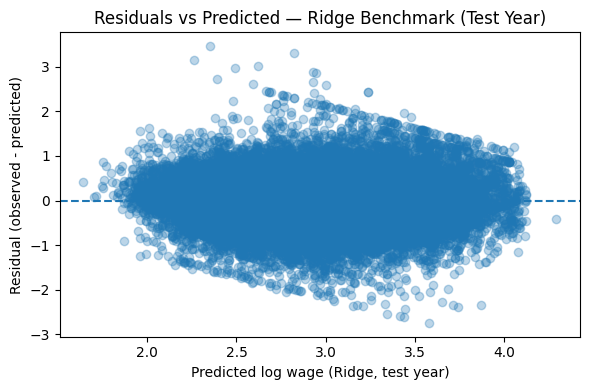

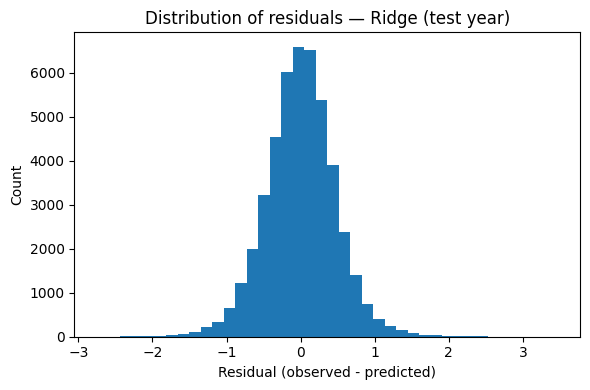

In [8]:
resid_test_rg = y_test - y_test_rg

plt.figure(figsize=(6, 4))
plt.scatter(y_test_rg, resid_test_rg, alpha=0.3)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted log wage (Ridge, test year)")
plt.ylabel("Residual (observed - predicted)")
plt.title("Residuals vs Predicted — Ridge Benchmark (Test Year)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(resid_test_rg, bins=40)
plt.xlabel("Residual (observed - predicted)")
plt.ylabel("Count")
plt.title("Distribution of residuals — Ridge (test year)")
plt.tight_layout()
plt.show()

#### Key Points:

Residuals cluster heavily around zero. Dispersion is roughly constant, aside from a few outliers at the upper end of the  distribution, and the pattern is stable and symmetric.

## 6.4 LR vs Ridge performance

In [9]:
perf_summary = pd.DataFrame({
    "model": ["LinearRegression", "Ridge"],
    "train_R2": [lr_r2_train,  rg_r2_train],
    "test_R2":  [lr_r2_test,   rg_r2_test],
    "train_MAE": [lr_mae_train, rg_mae_train],
    "test_MAE":  [lr_mae_test,  rg_mae_test],
})

perf_summary

,model,train_R2,test_R2,train_MAE,test_MAE
0,LinearRegression,0.403958,0.414101,0.355889,0.363699
1,Ridge,0.403932,0.414057,0.355892,0.363712


#### Key points: 

Both models land on essentially the same solution.
R² and MAE align to the fourth decimal, and neither model gains or loses efficacy on the test set. Ridge doesn’t tighten the fit, but it also doesn’t destabilize anything. 

The takeaway: the wage structure in this cohort is linear enough that regularisation doesn’t change the outcome, which is desirable for a transparent benchmark.

## 6.5 Random Forest sanity check

In [10]:
n_subsample = min(20000, X_train_ml.shape[0])
X_train_sub = X_train_ml.sample(n=n_subsample, random_state=0)
y_train_sub = y_train.loc[X_train_sub.index]

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    n_jobs=-1,
    random_state=0,
)

rf.fit(X_train_sub, y_train_sub)

y_train_rf = rf.predict(X_train_sub)
y_test_rf  = rf.predict(X_test_ml)

rf_r2_train = r2_score(y_train_sub, y_train_rf)
rf_r2_test  = r2_score(y_test, y_test_rf)
rf_mae_test = mean_absolute_error(y_test, y_test_rf)

print("RandomForest (sanity check, subsample)")
print("  Train R² (subsample):", rf_r2_train)
print("  Test  R²            :", rf_r2_test)
print("  Test  MAE           :", rf_mae_test)

rf_compare = pd.DataFrame({
    "model": ["Ridge", "RandomForest_subsample"],
    "test_R2": [rg_r2_test, rf_r2_test],
    "test_MAE": [rg_mae_test, rf_mae_test],
})

rf_compare

RandomForest (sanity check, subsample)
  Train R² (subsample): 0.861036017180929
  Test  R²            : 0.345237490805002
  Test  MAE           : 0.384852781151247


,model,test_R2,test_MAE
0,Ridge,0.414057,0.363712
1,RandomForest_subsample,0.345237,0.384853


#### Key Findings:

A Random Forest fitted on a 20k subsample overfits (train R² = 0.86) and underperforms Ridge on the test year (R² = 0.35 vs. 0.41). This shows that the wage structure is close to linear and that a linear benchmark is the more stable and appropriate choice for deployment.

# 7) Fairness evaluation on the test year

In [11]:
abs_resid_test_rg = np.abs(resid_test_rg)

df_fair_ml = pd.DataFrame({
    "sex": df_test["sex"].to_numpy(),
    "residual": resid_test_rg.to_numpy(),
    "abs_residual": abs_resid_test_rg.to_numpy(),
})

fair_ml_summary = df_fair_ml.groupby("sex").agg(
    mean_residual=("residual", "mean"),
    mean_abs_error=("abs_residual", "mean"),
    count=("residual", "count"),
)

fair_ml_summary

,mean_residual,mean_abs_error,count
sex,,,
1,0.065274,0.371434,24109
2,-0.071589,0.355357,22282


#### Key Findings: 

- The model systematically overpredicts wages for men (mean residual ≈ +0.065) and systematically underpredicts for women (mean residual ≈ –0.072).
This is the expected pattern when gender is omitted from the model but a real gender wage gap exists in the data.

- Mean absolute errors are very similar for both groups.

- The sample sizes for men and women in the test set are reasonably balanced.

This check shows that a gender-blind model learns a single relationship between job factors and wages that applies equally to everyone, which forces it to overpredict for the higher-paid group (men) and underpredict for the lower-paid group (women).

# 8) Saving artifacts and model summary

### 8.1) Saving trained Ridge model

In [12]:
Path("../artifacts").mkdir(exist_ok=True)

model_path = "../artifacts/ridge_model.pkl"
joblib.dump(ridge_best, model_path)

['../artifacts/ridge_model.pkl']

### 8.2) Saving features list

In [13]:
model_features = list(X_train_ml.columns)

feature_list_path = "../artifacts/feature_list.json"
with open(feature_list_path, "w") as f:
    json.dump(model_features, f, indent=4)

### 8.3) Saving metrics for the app

In [14]:
fairness_by_sex = {}
for sex_value in fair_ml_summary.index:
    fairness_by_sex[str(sex_value)] = {
        "mean_residual": float(fair_ml_summary.loc[sex_value, "mean_residual"]),
        "mean_abs_error": float(fair_ml_summary.loc[sex_value, "mean_abs_error"]),
        "count": int(fair_ml_summary.loc[sex_value, "count"])
    }

metrics = {
    "model_version": "v1.0_nb4_ridge",
    "model_type": "Ridge",
    "target": target_col,
    "uses_sex_as_feature": False,
    "train_years": sorted(int(y) for y in df_train["year"].unique()),
    "test_year": int(latest_year),
    "train_r2": float(rg_r2_train),
    "test_r2": float(rg_r2_test),
    "train_mae": float(rg_mae_train),
    "test_mae": float(rg_mae_test),
    "alpha": float(best_alpha),
    "baseline_linear": {
        "train_r2": float(lr_r2_train),
        "test_r2": float(lr_r2_test),
        "train_mae": float(lr_mae_train),
        "test_mae": float(lr_mae_test),
    },
    "fairness_by_sex_test": fairness_by_sex
}

metrics_path = "../artifacts/model_metrics.json"
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=4)

#### Final Conclusions:

This notebook completes the gender-blind wage benchmark for the EquityLens audit tool.

- Both LinearRegression() and Ridge converge on essentially the same solution, with R² just above 0.41 on the test year and closely matched MAE.

- Ridge is selected for deployment because it keeps coefficients well-behaved in a large dummy-encoded feature set while preserving the same level of accuracy as LR.

- A small Random Forest check shows that more flexible non-linear models do not improve fit for this dataset.

- Test year residuals by sex show the expected pattern from a gender-blind benchmark: slight overprediction for men, slight underprediction for women, and very similar absolute errors.

The following artifacts are written for the Streamlit app:

- `ridge_model.pkl` (Ridge + StandardScaler pipeline)
- `feature_list.json` (expected feature layout)
- `model_metrics.json` (performance and residual-by-sex summary for display in the UI)


### End of Notebook 4